In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys, glob

In [3]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import matplotlib.dates as mdates

In [4]:
from datetime import datetime

In [5]:
DATA_DIR = "../csse_covid_19_data/csse_covid_19_daily_reports"

In [6]:
# sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="whitegrid")
# sns.set(font_scale = 2)
# sns.set_style("whitegrid", {'grid.linestyle': ':'})

## Data loading

In [7]:
csv_files = glob.glob(DATA_DIR + "/*.csv")

In [8]:
def extract_date(file_name):
    date_str = os.path.basename(file_name)[:-4]
#     print(date_str)
    
#     date = datetime.strptime(match.group(), '%Y-%m-%d').date()
    date = datetime.strptime(date_str, '%m-%d-%Y').date()
#     print(date)
    
    return date

In [9]:
world_df = None

for csv_file in csv_files:
    
    df = pd.read_csv(csv_file)
    date = extract_date(csv_file)
    df['Date'] = date
    
    if world_df is None:
        world_df = df
    else:
        world_df = pd.concat((world_df, df), ignore_index=True)
    
#     break

### Setup individual country

In [10]:
# Uncomment in case you want to check the list of countries with available data

# world_df['Country/Region'].unique()

In [11]:
country_name = "Italy"
ESTIMATED_IC_CAPACITY = 5000

# country_name = "Sweden"
# ESTIMATED_IC_CAPACITY = 1000

In [12]:
# Get data for a single country, sorted by date

country_df = world_df[world_df['Country/Region'] == country_name].sort_values(by='Date')

# Estimate a reasonable value for Y tick given the maximum number of cases
Y_GRID_TICK = 10**int(np.log10(country_df['Confirmed'].max()))/2

In [13]:
# Uncomment to check data for a specific day

country_df[country_df['Date'] == datetime.strptime("03-03-2020", '%m-%d-%Y').date()]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude
4371,NaN,Italy,2020-03-03T20:03:06,2502.0,79.0,160.0,2020-03-03,43.0,12.0


In [14]:
# Check latest data

country_df.tail()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude
3376,NaN,Italy,2020-03-08T18:03:04,7375.0,366.0,622.0,2020-03-08,43.0,12.0
242,NaN,Italy,2020-03-09T18:13:11,9172.0,463.0,724.0,2020-03-09,43.0,12.0
2795,NaN,Italy,2020-03-10T17:53:02,10149.0,631.0,724.0,2020-03-10,43.0,12.0
707,NaN,Italy,2020-03-11T21:33:02,12462.0,827.0,1045.0,2020-03-11,43.0,12.0
1827,NaN,Italy,2020-03-11T21:33:02,15113.0,1016.0,1258.0,2020-03-12,43.0,12.0


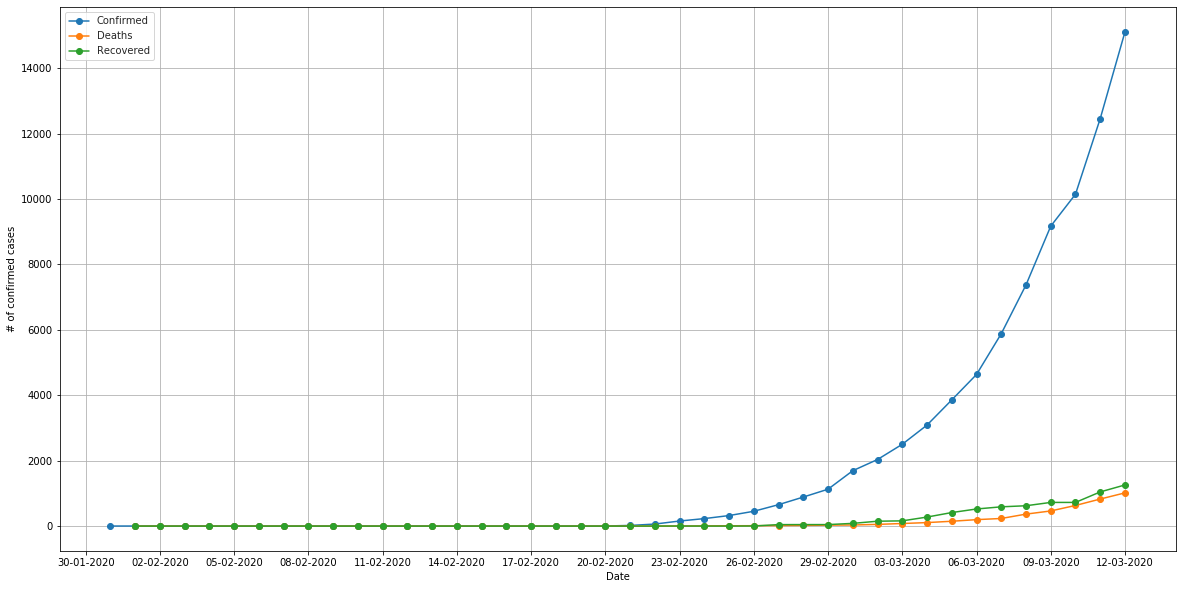

In [15]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

country_df.plot(x='Date', y=["Confirmed", "Deaths"], figsize=(20,10), ax=ax, marker='o')
country_df.plot(x='Date', y=["Recovered"], figsize=(20,10), ax=ax, marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylabel("# of confirmed cases");

plt.savefig("daily_data.png");

$y = e^{ax}$

$\ln{y} = ax$

## ML analysis

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# Set range of data to build model

# It might make sense to skip part of the initial points, when the exponential trend was still not evident
RANGE_START = 0
RANGE_END = None

In [18]:
y = np.log(country_df['Confirmed'])
x = np.arange(len(y))

In [19]:
reg = LinearRegression()
reg.fit(x[RANGE_START:RANGE_END][:,np.newaxis], y[RANGE_START:RANGE_END])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Create dataframe with estimates

In [20]:
estimate_dates = pd.date_range(start='1/31/2020', end='03/15/2020')
estimate_cases = np.exp(reg.predict(np.arange(len(estimate_dates))[:, np.newaxis]))

In [21]:
df_estimates = pd.DataFrame({"Date": estimate_dates, "Predictions": estimate_cases})

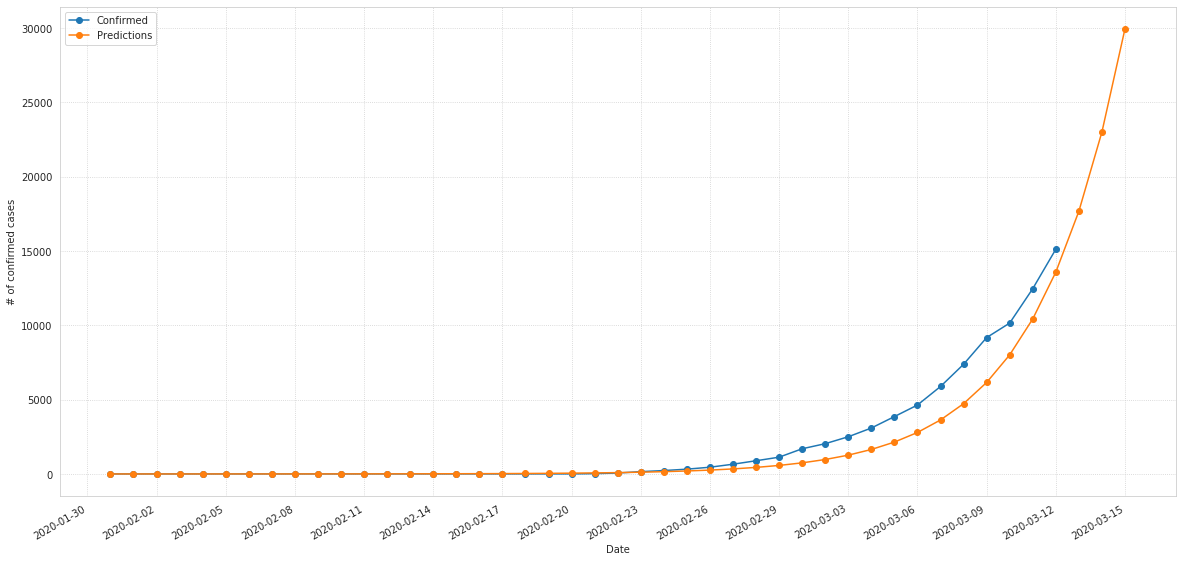

In [22]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions"], figsize=(20,10), ax=ax, marker='o')


# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of confirmed cases");

plt.savefig("confirmed_cases_prediction.png");

# Use lines below in case you want to highlight a specific date/value

# ax.axhline(9172, 0, 1, ls=':', color='red')
# ax.axvline("2020-03-09", 0, 1, ls=':', color='red')

### Estimate people in IC

Assume that 10% of infected people require a bed in IC

In [23]:
country_df['Confirmed_IC'] = country_df['Confirmed']*0.1
df_estimates['Predictions_IC'] = df_estimates['Predictions']*0.1
df_estimates['IC caspacity (national)'] = ESTIMATED_IC_CAPACITY

### Plot results

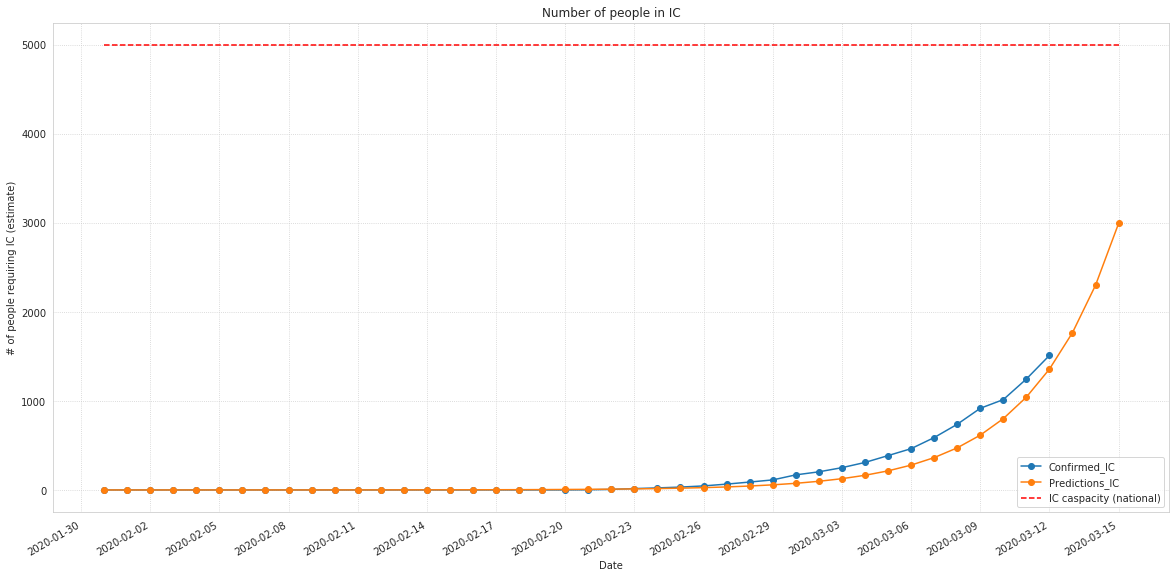

In [24]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--')
plt.title("Number of people in IC");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of people requiring IC (estimate)");

plt.savefig("IC_estimates.png");

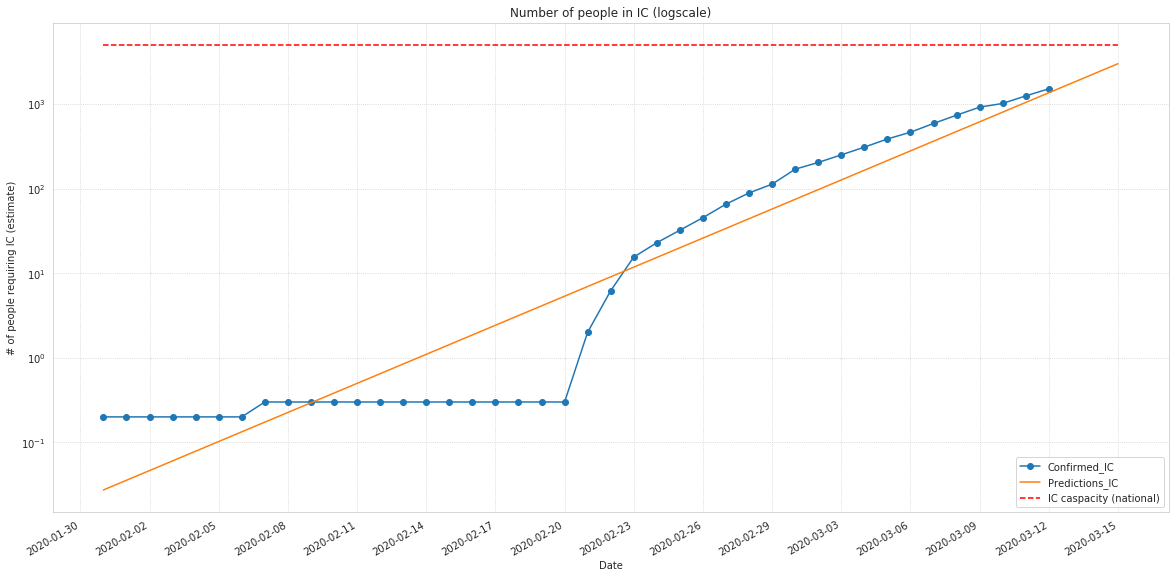

In [25]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions_IC"], figsize=(20,10), ax=ax)
df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--', logy=True)
plt.title("Number of people in IC (logscale)");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of people requiring IC (estimate)");

plt.savefig("IC_estimates_logscale.png");

## Countries comparison

Dates for Italy, Norway and Sweden have been manually aligned so that trends overlap.

In addition to that, data from Italy is truncated (data from the last 9 days is omitted) so that it doesn't make lines from other countries difficult to see.

In [26]:
def get_country_df(world_df, country_name):
    
    # Some countries have several Provinces/States, must aggregate
    country_df = world_df[world_df['Country/Region'] == country_name] \
        .groupby(["Country/Region", "Date"]) \
        .sum() \
        .sort_values(by='Date')
    
    # Restore columns
    country_df['Country/Region'] = [i[0] for i in country_df.index]
    country_df['Date'] = [i[1] for i in country_df.index]
    
    return country_df
#     return world_df[world_df['Province/State'] == country_name].sort_values(by='Date')

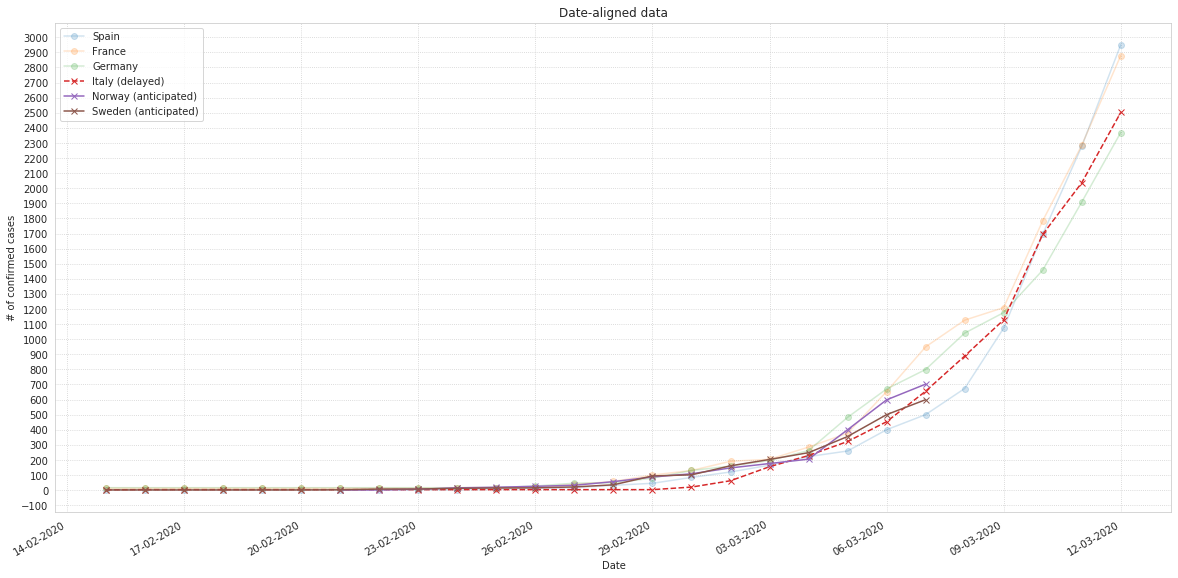

In [27]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


countries_to_plot = [
#     "Italy",
    "Spain",
    "France",
    "Germany",
#     "Norway",
#     "Sweden",
]

for cc in countries_to_plot:
    c_df = get_country_df(world_df, cc)
    c_df = c_df[c_df['Date'] > datetime(2020, 2,14).date()]
    
    c_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o', alpha=0.2)
    pass

italy_delayed = get_country_df(world_df, "Italy")
italy_delayed = italy_delayed.iloc[:-9,:]

# TODO THe number here must be changed daily
# Adjust date
italy_delayed['Date'] = list(get_country_df(world_df, "Spain")['Date'][-33:])

# TODO THe dates here must be changed daily
norway_anticipated = get_country_df(world_df, "Norway")
norway_anticipated['Date'] = pd.date_range(end="03-07-2020", periods=len(norway_anticipated))

sweden_anticipated = get_country_df(world_df, "Sweden")
sweden_anticipated['Date'] = pd.date_range(end="03-07-2020", periods=len(sweden_anticipated))

# Plot adjusted countries
italy_delayed = italy_delayed[italy_delayed['Date'] > datetime(2020, 2,14).date()]
italy_delayed.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x', ls="--")

norway_anticipated = norway_anticipated[norway_anticipated['Date'] > "2020-02-14"]
sweden_anticipated = sweden_anticipated[sweden_anticipated['Date'] > "2020-02-14"]

norway_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')
sweden_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')

ax.legend(countries_to_plot + ['Italy (delayed)', 'Norway (anticipated)', 'Sweden (anticipated)'])
ax.set_ylabel("# of confirmed cases")

plt.title("Date-aligned data");

plt.savefig("europe_aligned_dates.png");

In [28]:
get_country_df(world_df, "Spain").tail()

Confirmed  Deaths  Recovered  Latitude  Longitude  \
Country/Region Date                                                            
Spain          2020-03-08      673.0    17.0       30.0      40.0       -4.0   
               2020-03-09     1073.0    28.0       32.0      40.0       -4.0   
               2020-03-10     1695.0    35.0       32.0      40.0       -4.0   
               2020-03-11     2277.0    54.0      183.0      40.0       -4.0   
               2020-03-12     2950.0    84.0      183.0      40.0       -4.0   

                          Country/Region        Date  
Country/Region Date                                   
Spain          2020-03-08          Spain  2020-03-08  
               2020-03-09          Spain  2020-03-09  
               2020-03-10          Spain  2020-03-10  
               2020-03-11          Spain  2020-03-11  
               2020-03-12          Spain  2020-03-12

In [29]:
get_country_df(world_df, "Spain")['Confirmed'][-1]

2950.0

In [33]:

daily_increase_df = pd.DataFrame(columns=['Country', 'Date', 'Increase'])

N_data_points = 10

countries = [
    'Spain', 
    'France', 
    'Germany', 
    'Italy', 
    'Norway', 
    'Sweden',
]

for c in countries:

    c_df = get_country_df(world_df, c)

    for i in range(N_data_points):
        inc = c_df['Confirmed'][-N_data_points+i]/c_df['Confirmed'][-N_data_points+i-1]

        daily_increase_df_row = pd.DataFrame.from_dict({'Country': [c], 'Date': [c_df['Date'][-N_data_points+i]], 'Increase': [inc]})

        daily_increase_df = pd.concat((daily_increase_df, daily_increase_df_row), ignore_index=True)
        
daily_increase_df['Increase_p'] = (daily_increase_df['Increase'] - 1) * 100

/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5008daa610> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5008d39ad0> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5008d4be10> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5008d66d90> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-

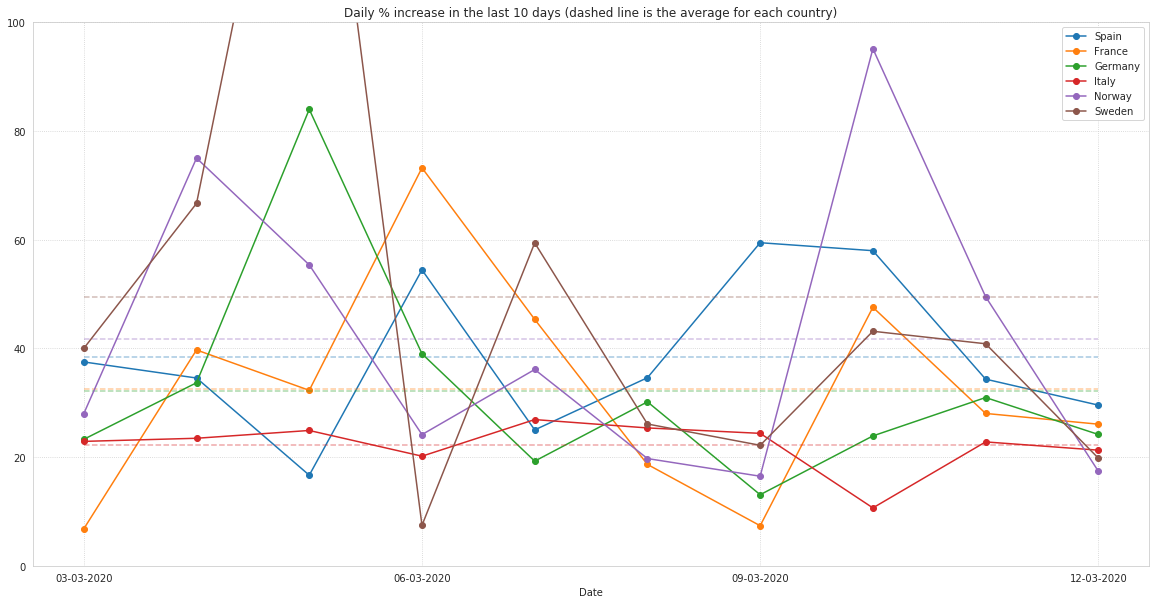

In [35]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


legend_strings = list()


for c in countries:
    
    daily_increase_df_country = daily_increase_df[daily_increase_df['Country'] == c].copy()
    
    daily_increase_df_country['Average'] = daily_increase_df_country['Increase'].mean()
    daily_increase_df_country['Average_p'] = daily_increase_df_country['Increase_p'].mean()
    
    # Plot daily increase
    daily_increase_df_country.plot(x='Date', y=["Increase_p"], figsize=(20,10), ax=ax, marker='o')
    
#     ax.lines[-1].set_label(c)
    
    # Plot mean (no label)
    
    daily_increase_df_country.plot(
        x='Date', y=["Average_p"], 
        figsize=(20,10), ax=ax, ls="--", alpha=0.4, color=ax.lines[-1].get_color(), legend=False)
    
#     print(dir(ax.lines[-1]))
    
#     ax.lines[-1].set_label("_")
    
#     legend_strings.extend([c, f"{c} (average)"])
    legend_strings.extend([c, "_"])
    
ax.legend(legend_strings)
# ax.legend(countries)

# Limit y range to increase visibility
# ax.set_ylim(1, 2.2);
ax.set_ylim(0, 100);

ax.set_title("Daily % increase in the last 10 days (dashed line is the average for each country)");
plt.savefig("europe_daily_increase_10days.png");
